## $\textbf{Labeling Apple Watch Time Signature Data for a Right-Handed Conductor}$

$\textbf{Author:}\text{ Ryan Burns}$

$\text{SensorLog labels are recorded in real time using the app's class label buttons for a streaming iPhone. This iPhone logs data concurrently with}$
$\text{an Apple Watch, which also reports its own class labels. Since toggling of the Apple Watch's class labels using the SensorLog UI on the watch }$
$\text{face would interfere with data collection of wrist motion, we use the }\textit{iPhone}\text{ to log wrist motion labels. By time-aligning the iPhone and Apple}$
$\text{Watch streams below (i.e., using POSIX timestamps), we can readily provide wrist motion labels for the Apple Watch motion signals without}$
$\text{interfering with their trajectory as just described. In short, real-time motion labeling is available through dual stream of Apple Watch and iPhone}$
$\text{data, where the former provides the motion observations of interest, whereas the latter provides a mechanism for real-time motion labeling.}$

$\text{Assume all data is logged at 100 Hz.}$

$\textbf{Motion Class Labels:}$

$\text{All class labels are defined for a right-handed user. An orchestral conductor varies their baton pattern according to 1 of 4 possible states, }$
$\text{comprised of 3 time signature classes and a resting class (i.e., cessation of baton motion).}$

$\text{0 }\leftrightarrow [1\enspace0\enspace0\enspace0]\leftrightarrow \text{REST}\Longrightarrow\text{conductor has ceased baton motion (no conducting)}$

$\text{1 }\leftrightarrow [0\enspace1\enspace0\enspace0]\leftrightarrow {2/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{2}{4}}\text{ time signature}$

$\text{2 }\leftrightarrow [0\enspace0\enspace1\enspace0]\leftrightarrow {3/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{3}{4}}\text{ time signature}$

$\text{3 }\leftrightarrow [0\enspace0\enspace0\enspace1]\leftrightarrow {4/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{4}{4}}\text{ time signature}$

$\text{For more information on musical time signatures, visit: }\textit{https://en.wikipedia.org/wiki/Time_signature}.$

![title](baton_motion.png)

$\text{The baton patterns for each time signature of interest are depicted diagramatically above. We assume a tech enthusiast conductor who desires}$
$\text{an Apple Watch app/experience for automatic discrimination between the 3 time signatures above, in addition to a catch-all }\textit{at-rest}\text{ state. We }$
$\text{also assume that this conductor would like automatic time-signature inference to be as tempo-agnostic as possible. Be it }\textit{largo}\text{ or }\textit{prestissimo}\text{, we}$
$\text{assume that the tempo of the musical composition of question would not fool the ideal baton pattern classifier. As such, while the amount of data }$
$\text{collected for this analysis is still limited in its size and diversity (i.e., we can assume overfit models), efforts have been made during data collection }$
$\text{to vary the tempo across each time signature's constituent wrist motion observations. The duration (in seconds or measures) of each time signature's}$
$\text{wrist motion subsequence is also varied during collection.}$

### $\textbf{Import Packages}$

In [1]:
import pandas as pd
import datetime;
import time;
from os import getcwd;
from matplotlib import pyplot as plt
from numpy import argwhere, argmin, shape;
from numpy import array, hstack, argmax, ones, zeros, log10, min;
from numpy import logical_or, logical_not, expand_dims, abs, max;
from SensorLogUtils import convert_iPhone_units;
from SensorLogUtils import convert_appleWatch_units;

### $\textbf{Class Label Definitions}$

In [2]:
# Ordinal motion class labels
class_table = pd.DataFrame({
    'REST': {
        'id': 'REST', 
        'description': 'no conducting / baton pattern',
        '1-hot label': [1,0,0,0],
        'ordinal label': 0
    },
    '2/4': {
        'id': '2/4', 
        'description': 'conducting pattern for a 2/4 time signature',
        '1-hot label': [0,1,0,0],
        'ordinal label': 1
    },
    '3/4': {
        'id': '3/4', 
        'description':'conducting pattern for a 3/4 time signature',
        '1-hot label': [0,0,1,0],
        'ordinal label': 2
    },
    '4/4': {
        'id': '4/4', 
        'description':'conducting pattern for a 4/4 time signature',
        '1-hot label': [0,0,0,1],
        'ordinal label': 3
    }
});

# Number of classes
C = 4;

# Print class table
class_table

,REST,2/4,3/4,4/4
id,REST,2/4,3/4,4/4
description,no conducting / baton pattern,conducting pattern for a 2/4 time signature,conducting pattern for a 3/4 time signature,conducting pattern for a 4/4 time signature
1-hot label,"[1, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]"
ordinal label,0,1,2,3


### $\textbf{Specify & Load Dataset}$

In [3]:
################
# Specify data #
################

# Specify local data storage path
data_path = getcwd() + '/../data';

# Collect file string ID
collect_ID = 'time_signatures_collect5';

# Build string filename corresponding to collect_ID
iPhone_file = data_path + '/' + collect_ID + '_iPhone.csv';
appleWatch_file = data_path + '/' + collect_ID + '_appleWatch.csv';

#############
# Load data #
#############

# Load iPhone dataset to pandas DataFrame
iPhone = pd.read_csv(
    iPhone_file, 
    error_bad_lines=False,
    warn_bad_lines=False);

# Load Apple watch dataset to pandas DataFrame
appleWatch = pd.read_csv(
    appleWatch_file, 
    error_bad_lines=False,
    warn_bad_lines=False);

##################
# Gather headers #
##################

# Data fields (i.e., column headers) for each device
iPhone_fields = [fd for fd in iPhone];
appleWatch_fields = [fd for fd in appleWatch];

# Convert units of some iPhone columns
iPhone = convert_iPhone_units(iPhone);

# Convert units of some Apple Watch columns
appleWatch = convert_appleWatch_units(appleWatch);

# Remove orig. label column from raw Apple Watch collect
if (('1' in collect_ID) or ('2' in collect_ID)):
    appleWatch.drop(columns=['label'],inplace=True);

### $\textbf{Extract POSIX Timestamps for Each Device}$

In [4]:
# Apple watch's POSIX format timestamps
tPOSIX_watch = [datetime.datetime.strptime(
    tn.replace(' -0400',''),'%Y-%m-%d %H:%M:%S.%f').timestamp()
    for tn in appleWatch['loggingTime(txt)']];

# iPhone's POSIX format timestamps
tPOSIX_phone = [datetime.datetime.strptime(
    tn.replace(' -0400',''),'%Y-%m-%d %H:%M:%S.%f').timestamp()
    for tn in iPhone['loggingTime(txt)']];

### $\textbf{Truncate Device Data To Interval of Simultaneous Logging}$

In [5]:
#########################################################
# Extract interval [t_min,tmax] w/ both devices logging #
#########################################################

# The later of each device's earliest timestamp
t_min = max([min(tPOSIX_watch),min(tPOSIX_phone)]);

# The earlier of each device's final timestamp
t_max = min([max(tPOSIX_watch),max(tPOSIX_phone)]);

#########################################################
# Find indices within timespan [t_min,t_max] per device #
#########################################################

# Index into Apple Watch timestamps to extract sample indices 
# at which they coincide temporally with the iPhone timestamps
idx_watch = argwhere((tPOSIX_watch >= t_min) \
    & (tPOSIX_watch <= t_max)).flatten();

# Index into iPhone timestamps to extract sample indices at 
# which they coincide temporally with the Apple Watch timestamps
idx_phone = argwhere((tPOSIX_phone >= t_min) \
    & (tPOSIX_phone <= t_max)).flatten();

#############################################################
# Index into device dataframes, truncating to [t_min,t_max] #
#############################################################

# First, truncate POSIX timestamp variables to [t_min,t_max]
tPOSIX_watch = array([tPOSIX_watch[idx] for idx in idx_watch]);
tPOSIX_phone  = array([tPOSIX_phone[idx] for idx in idx_phone]);

# Now, truncate original dataframes
appleWatch = appleWatch.iloc[idx_watch];
iPhone = iPhone.iloc[idx_phone];

# Reset dataframe indices
appleWatch.reset_index(inplace=True,drop=True);
iPhone.reset_index(inplace=True,drop=True);

### $\textbf{Map Motion Labels Logged via iPhone to Apple Watch Sample Indices}$

In [6]:
# Ordinal wrist motion labels from iPhone
y_iPhone = array(iPhone['label(N)']);

# Define Apple watch ordinal labels as the label of the
# nearest iPhone sample (via POSIX |timestamp difference|)
y_appleWatch = array([
    y_iPhone[argmin(abs(tPOSIX_phone - tPOSIX_watch[n]))]
    for n in range(len(appleWatch))
]);

# Define 1-hot class labels using ordinal labels
Y_appleWatch = array([[
    1 if (c == y_appleWatch[n]) else 0 for c in range(C)] 
    for n in range(len(y_appleWatch))]);

### $\textbf{Time Domain Signals & Labels}$

<IPython.core.display.Javascript object>


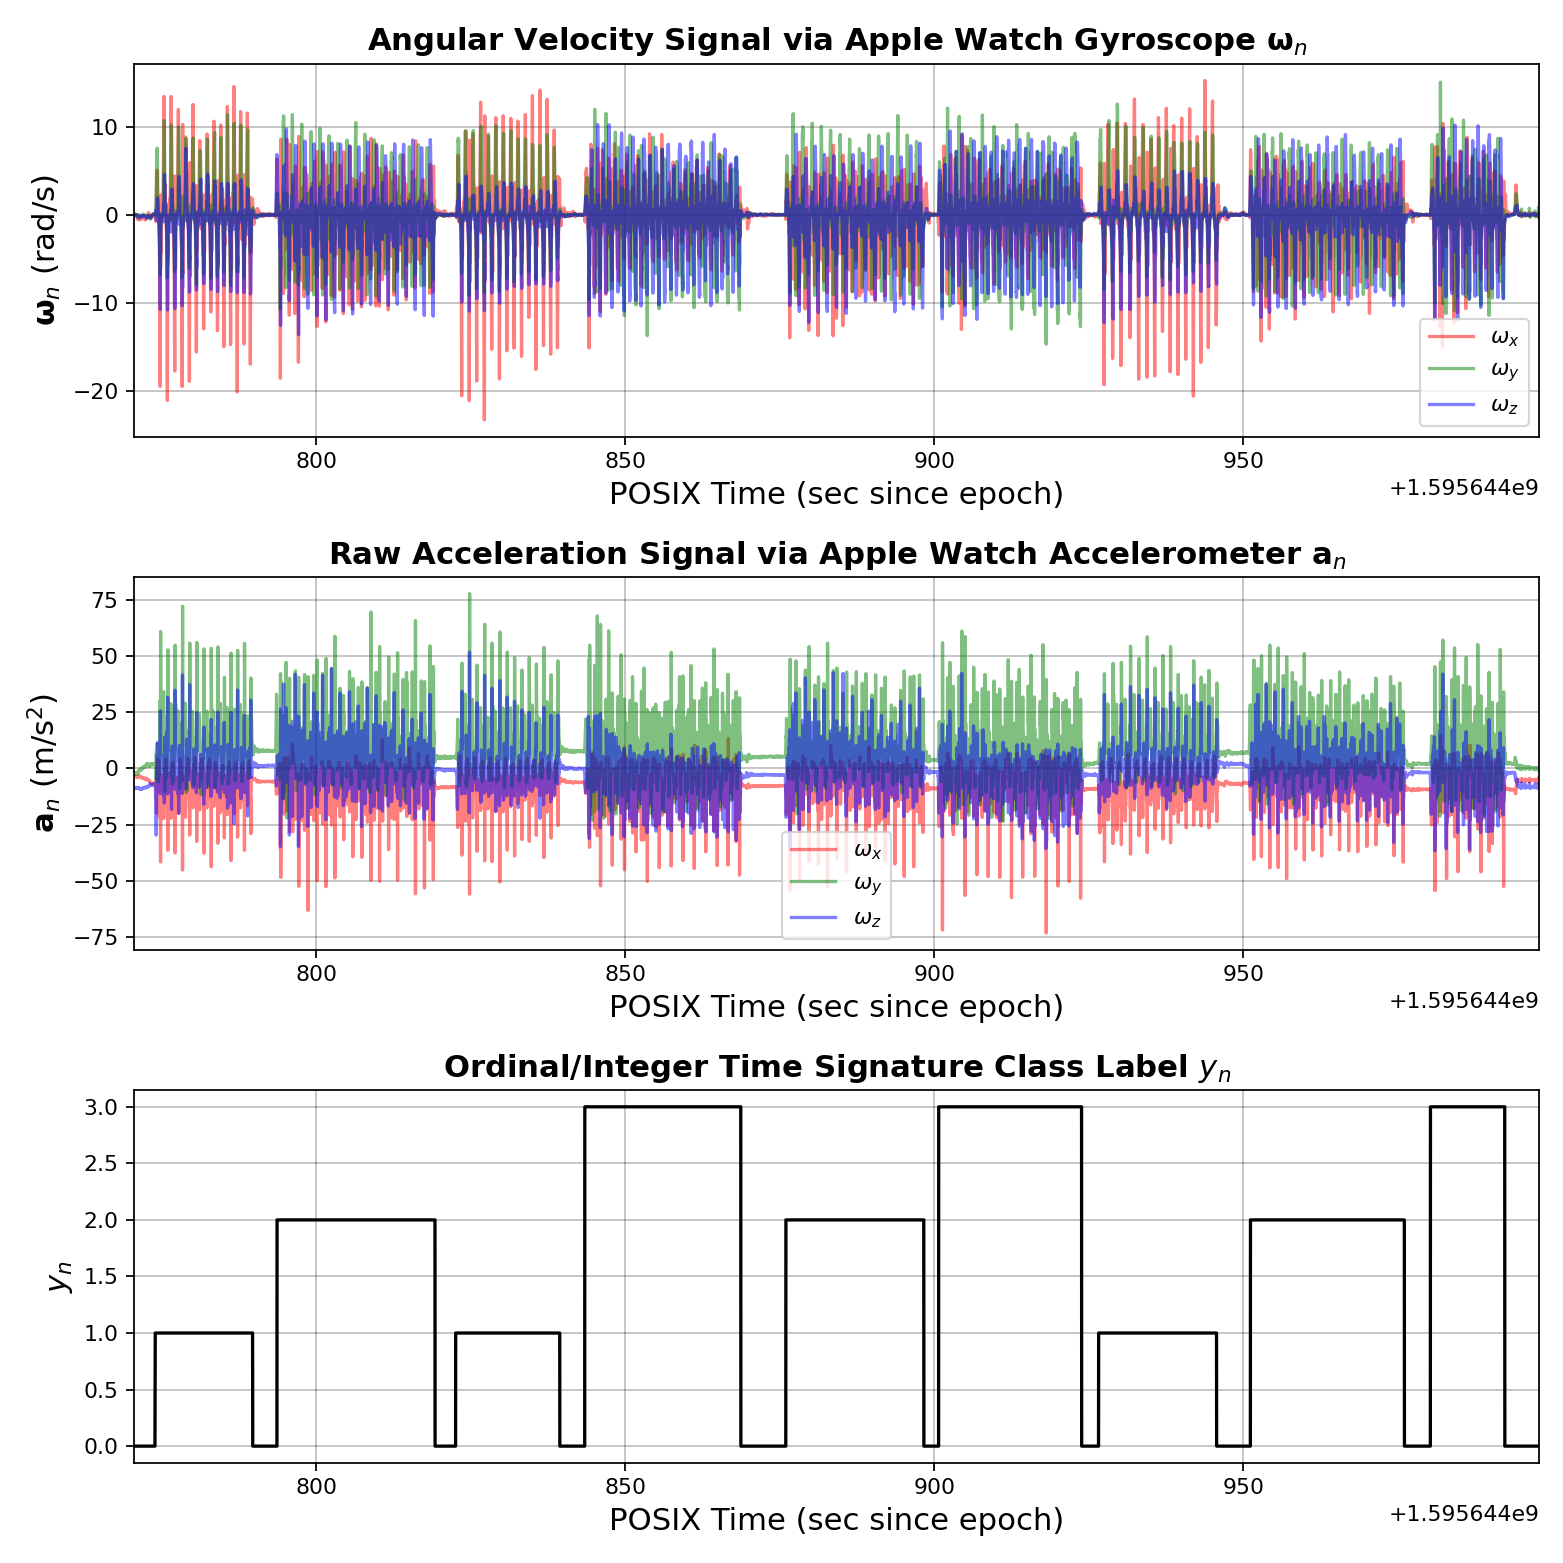

In [7]:
%matplotlib notebook

plt.figure(figsize=(9.9,9.9));

#########################
# Apple Watch Gyroscope #
#########################
ax1 = plt.subplot(3,1,1);

# Add grid to axes
plt.grid(alpha=0.25,color='k');

# Plot the Apple watch gyroscope signal logged during collection
plt.plot(tPOSIX_watch,appleWatch['motionRotationRateX(rad/s)'],
         c='r',alpha=0.5,label='$\omega_x$');
plt.plot(tPOSIX_watch,appleWatch['motionRotationRateY(rad/s)'],
         c='g',alpha=0.5,label='$\omega_y$');
plt.plot(tPOSIX_watch,appleWatch['motionRotationRateZ(rad/s)'],
         c='b',alpha=0.5,label='$\omega_z$');

# x-axis limits
plt.xlim([
    min(tPOSIX_watch),
    max(tPOSIX_watch)
]);

# x-axis label
plt.xlabel(r'POSIX Time (sec since epoch)',fontsize=14);

# y-axis label
plt.ylabel(r'$\mathbf{\omega}_n$ (rad/s)',fontsize=14);

# Title
plt.title(r'Angular Velocity Signal via Apple Watch Gyroscope $\mathbf{\omega}_n$',
          fontsize=14, weight='bold');

# Add legend
plt.legend();

#############################
# Apple Watch Accelerometer #
#############################
ax1 = plt.subplot(3,1,2,sharex=ax1);

# Add grid to axes
plt.grid(alpha=0.25,color='k');

# Plot the Apple watch gyroscope signal logged during collection
plt.plot(tPOSIX_watch,appleWatch['accelerometerAccelerationX(m/s^2)'],
         c='r',alpha=0.5,label='$\omega_x$');
plt.plot(tPOSIX_watch,appleWatch['accelerometerAccelerationY(m/s^2)'],
         c='g',alpha=0.5,label='$\omega_y$');
plt.plot(tPOSIX_watch,appleWatch['accelerometerAccelerationZ(m/s^2)'],
         c='b',alpha=0.5,label='$\omega_z$');

# x-axis limits
plt.xlim([
    min(tPOSIX_watch),
    max(tPOSIX_watch)
]);

# x-axis label
plt.xlabel(r'POSIX Time (sec since epoch)',fontsize=14);

# y-axis label
plt.ylabel(r'$\mathbf{a}_n$ (m/s${}^2$)',fontsize=14);

# Title
plt.title(r'Raw Acceleration Signal via Apple Watch Accelerometer $\mathbf{a}_n$',
          fontsize=14, weight='bold');

# Add legend
plt.legend();

#############################
# Label Sequence via iPhone #
#############################
ax1 = plt.subplot(3,1,3,sharex=ax1);

# Add grid to axes
plt.grid(alpha=0.25,color='k');

# Plot the Apple watch gyroscope signal logged during collection
plt.plot(tPOSIX_watch,y_appleWatch, c='k');

# x-axis limits
plt.xlim([
    min(tPOSIX_watch),
    max(tPOSIX_watch)
]);

# x-axis label
plt.xlabel(r'POSIX Time (sec since epoch)',fontsize=14);

# y-axis label
plt.ylabel(r'$y_n$',fontsize=14);

# Title
plt.title(r'Ordinal/Integer Time Signature Class Label $y_n$',
          fontsize=14, weight='bold');

# Optimize subplots layout
plt.tight_layout();

### $\textbf{Labeled Time Series - A Top-Down Image View}$

<IPython.core.display.Javascript object>


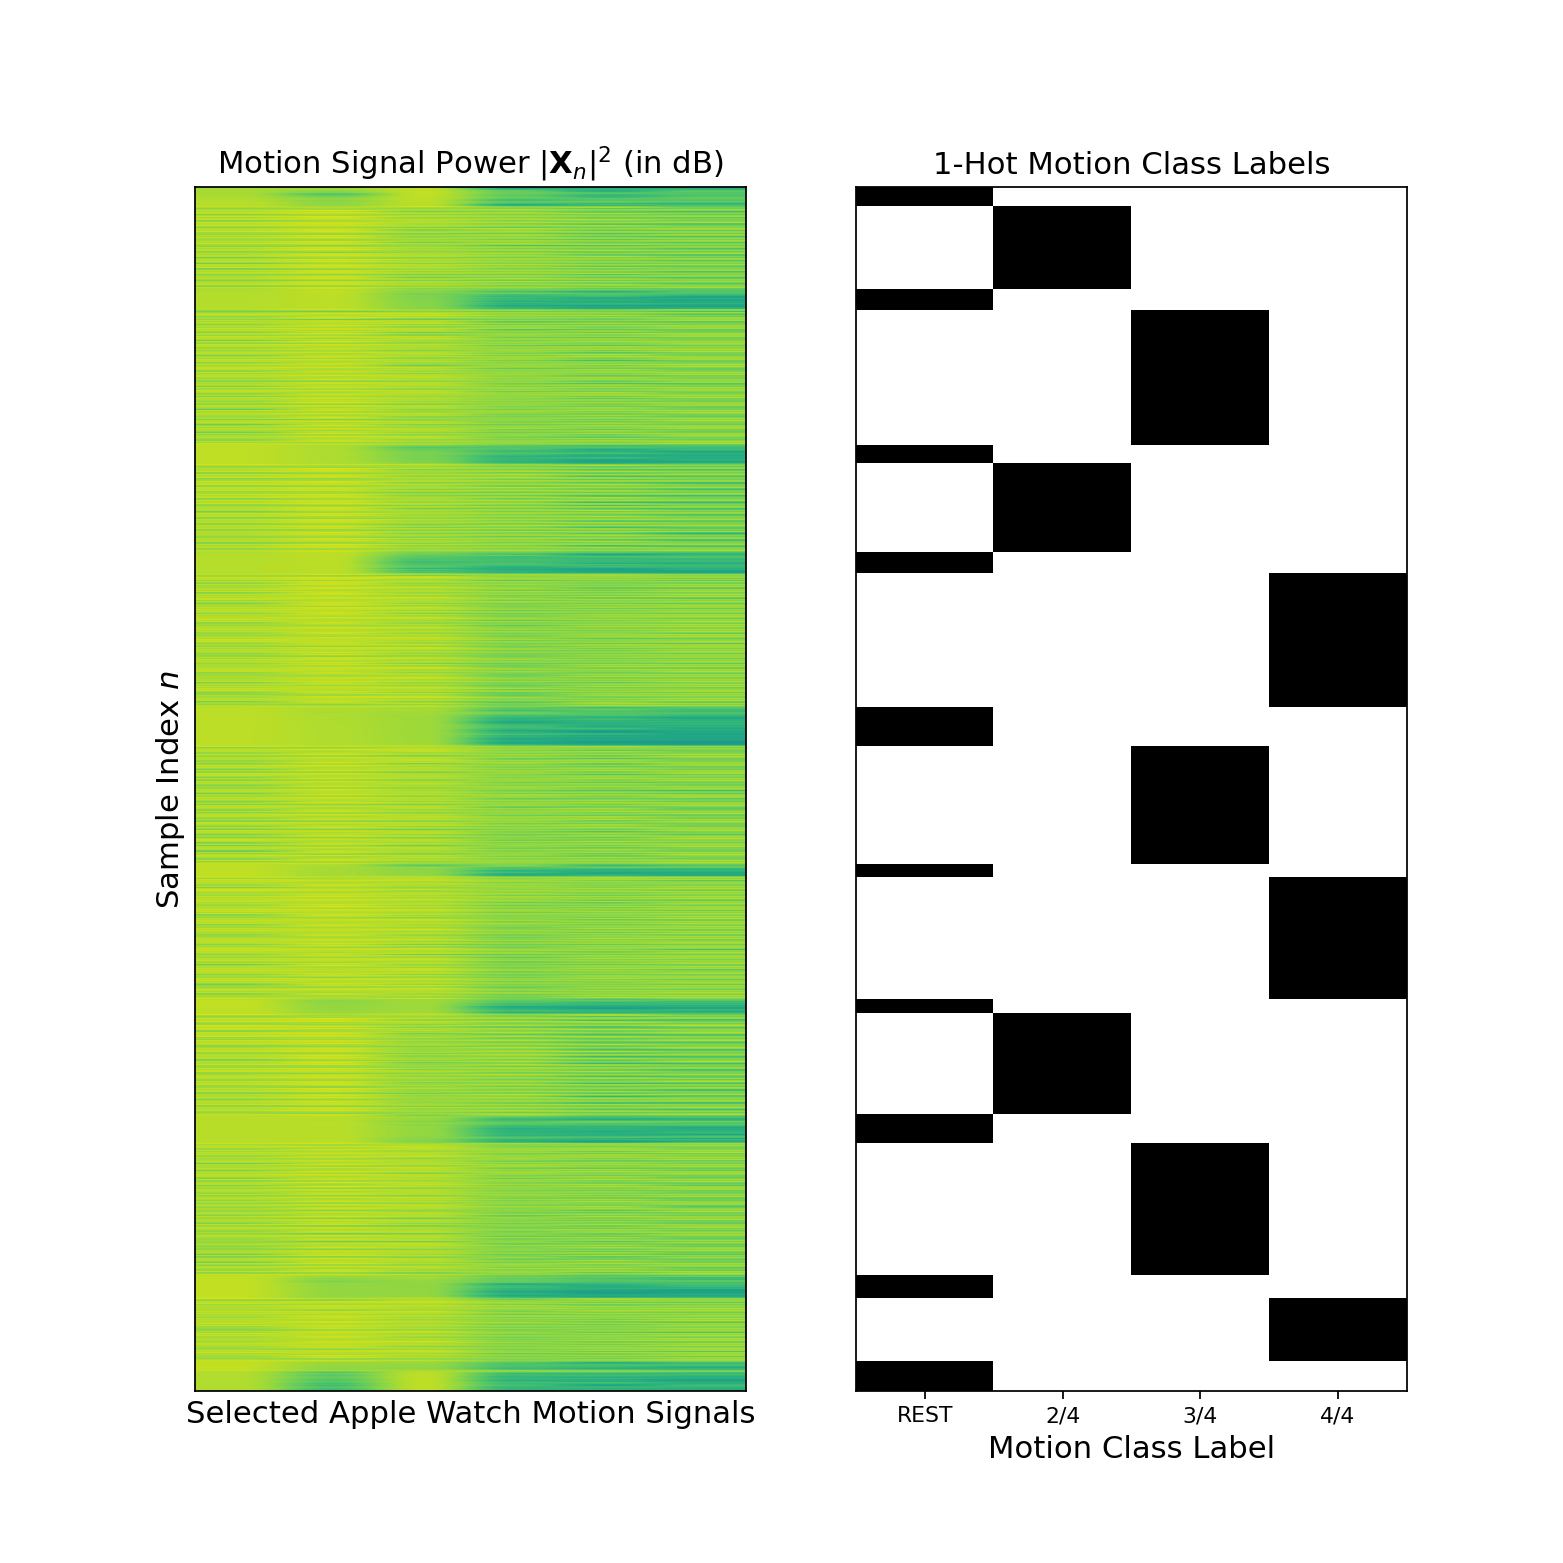

In [8]:
# New figure
plt.figure(figsize=(9.9,9.9));

#############################
# Plot motion data as image #
#############################

# Right subplot
ax1 = plt.subplot(1,2,1);

# iPhone data subset --> array X
X = array(appleWatch[
    [
        'accelerometerAccelerationX(m/s^2)',
        'accelerometerAccelerationY(m/s^2)',
        'accelerometerAccelerationZ(m/s^2)',
        'motionRotationRateX(rad/s)',
        'motionRotationRateY(rad/s)',
        'motionRotationRateZ(rad/s)',
    ]
]);

# Compute power, convert to dB
X = 20*log10(1e-8 + abs(X));

# Plot image of |X|^2 in dB
plt.imshow(X,aspect='auto');

# Omit ticks for simplicity
plt.xticks([]); plt.yticks([]);

# Add x-label
plt.xlabel(r'Selected Apple Watch Motion Signals',fontsize=14);

# Add x-label
plt.ylabel(r'Sample Index $n$',fontsize=14);

# Add title
plt.title(r'Motion Signal Power $|\mathbf{X}_n|^2$ (in dB)',
          fontsize=14);

##############################
# Plot 1-hot labels as image #
##############################

# Right subplot
ax2 = plt.subplot(1,2,2,sharey=ax1);

# Plot 1-hot motion class labels
plt.imshow(Y_appleWatch,aspect='auto',cmap='binary',
           interpolation='none');

# Label x-axis ticks explicitly using class labels
plt.xticks([0,1,2,3],[c for c in class_table]);
plt.yticks([]); # omit any y-ticks for simplicity

# Add x-label
plt.xlabel(r'Motion Class Label',fontsize=14);

# Add title
plt.title(r'1-Hot Motion Class Labels',fontsize=14);

### $\textbf{Add Labels & POSIX Timestamps to Apple Watch DataFrame}$

In [9]:
# Concatenate 1-hot & ordinal labels to dataframe
appleWatch = pd.concat([
    appleWatch,pd.concat([
        pd.DataFrame(tPOSIX_watch,
            columns=['t_POSIX']),
        pd.DataFrame(y_appleWatch,
            columns=['label']), 
        pd.DataFrame(Y_appleWatch,
            columns=[c for c in class_table])
],axis=1)],axis=1)

### $\textbf{Remove Unwanted Columns}$

In [10]:
# Remove columns which contain extraneous information
# or any potentially personally identifiable information
if (('1' in collect_ID) or ('2' in collect_ID)):
    
    # Combination of fields to drop for collects {1,2}
    appleWatch.drop(columns=[
        'accelerometerTimestamp_sinceReboot(s)',
        'motionTimestamp_sinceReboot(s)',
        'activityTimestamp_sinceReboot(s)',
        'activity(txt)',
        'activityActivityConfidence(Z)', 
        'activityActivityStartDate(txt)'
    ],inplace=True);

### $\textbf{Save Trimmed and Labeled Apple Watch DataFrame to CSV File}$

In [11]:
# Specify pickle file @ which to store the dataframe
csv_file = (getcwd() + '/data/labeled_' + 
    collect_ID + '_appleWatch.csv');

# Save labeled dataframe to CSV
appleWatch.to_csv(csv_file);